## Obtaining mechanically coupled regions in tissues

In tissues, one can see regions in which all nuclei are pointing in the same direction. This indicates that these nuclei are all experiencing the same tension and thereby are mechanically coupled. 

Here we aim to identify such regions in a tissues stained for the nucleus. Note that we are using instance segmented nuclear images. 

In [1]:
# import libraries
%load_ext autoreload
import sys
sys.path.append("..")

from tifffile import imread
import pandas as pd 
from skimage import measure
import src.spatial_features.mechanical_coupled_regions_clustering as MCR

#### Appproach:

First, we read in the segmented image and for each nucleus, we get the position, orientation and shape (eccentricity).We are interested only in elongated nuclei. This is because we assume that these nuclei are streched by the forces from their microenvironment. Also, as a side note, since we will be using the major axis of an ellipse to get the oritentation of the nuclei, the determination of the major axis will be less reliable in a perfectly circular nucleus.

Next, we perform Density-based spatial clustering of applications with noise (DBSCAN) by using the angles, and centroid cordiates of the elongated nuclei. The assumption is that nuclei with the similar angles in the similar spatial neighborhoods will be clustered together. 
We use a neighbourhood radius ε of 250 pixels and minimum size of a cluster to be 10 nuclei. Size was determined by a domain expert and ε was deterimined by using the elbow method in the 10th nearest neighbour plots for 5 random tissues. 

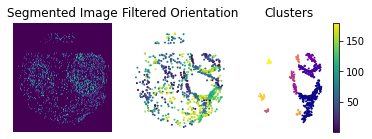

In [2]:
image_path = '/home/pathy_s/Documents/TMA/Stardist_seg_results/Instance_segmentation/BR2082B_H15.tif'
output_path = '/home/pathy_s/Documents/temp/'

#Read in the image that is segmented/labelled for nuclei
img=imread(image_path)

#Get features for the individual nuclei in the image
feat=measure.regionprops_table(img,properties = ('label','orientation','centroid','area','eccentricity'))

#Perform clustering
df=MCR.clustering_mech_coupled_regions(feat,250,10)
#Visualise clustering
MCR.vis_mechanically_coupled_regions(image_path,output_path,df,250,10, True)

#### Measuring cluster features
Once we have the clusters we measure the following categories of measurements (n=72). 

1) Clusterability (n=6) : 

| Feature | Description |
| --- | --- | 
| Number_nuclei_in_tissue | Number of detected in tissue |
| Number_of_ellongated_nuclei_in_tissue | Number of ellongated(Filtered) nuclei in tissue | 
| Number_of_clusters | Number of clustered detected |
| Number_of_ellongated_nuclei_unclusted | Number of ellongated nuclei that are not clustered (Noise) |
| Number_of_ellongated_nuclei_clustered | Number of ellongated nuclei that are clustered |
| Sil_score* | Silhhouette Value| 

2) Cluster memership, area and density (n=25):

| Feature | Description |
| --- | --- | 
| Cluster members* | Distribution characteristics of the number of nuclei per cluster for all clusters in tissue|  
| Cluster Area(pixels)*  | Distribution characteristics of the area of cluster as determined by the convex hull of cluster members and total area | 
| Cluster density*| Distribution characteristics of the number of nuclei/ convex area of cluster | 
| Total Cluster Area| Sum of all convex cluster areas | 

2) Homogeneity of angles in each cluster and the nucleus(n=25):

| Feature | Description |
| --- | --- | 
| Median clusterwise orientation dispersion  | Median dispersion measures of nuclear orientation within each cluster for all clusters in a tissue | 
| Standard deviaion clusterwise orientation dispersion | Standard deviaion dispersion measures of nuclear orientation within each cluster for all clusters in a tissue | 
| Orientation dispersion of uncoupled nuclei(noise) | Dispersion measures of nuclear orientation of all uncoupled ellongated nuclei in a tissue |
| Orientation dispersion of all nuclei | orientation dispersion of all nuclei in the tissue |
| Oientation dispersion of ellongated nuclei | orientation dispersion of only ellongated nuclei in the tissue| 


4) Spatial distribution of of the clusters (n=16): 

| Feature | Description | 
| --- | --- | 
| border-boder distances(pixels)* | Distribution characteristics of the minimum distances between clusters | 
| centroid-centroid distances(pixels)* | Distribution characteristics of the centeroid-centroid distances between clusters |  

Note:

Distribution measures include Median, Min, Max, Standard Deveiaion, Coefficient of Variation, Coefficient of Dispersion, InterQuartile Range and Quartile coeeficient of dispersion

Dispersion measures include Standard Deveiaion, Coefficient of Variation, Coefficient of Dispersion, InterQuartile Range and Quartile coeeficient of dispersion

\* Denotes measures that are computed only if the the number of clusters identified in the tissue is at least 2. 

In [3]:
#Sumarise the clustering results
cluster_summary= MCR.clusterability(feat, df)

#characterise the number, area and density of nuclei in a cluster
membership = MCR.cluster_membership_occupancy(df)

#characterise the nuclear angular distributions within a tissue and identified clusters
tissue_ang_dist = MCR.tissue_angular_homogenity(feat)
cluster_ang_dist = MCR.cluster_angular_homogenity(df)

#characterise the relative positioning of clusters within a tissue
cluster_positioning = MCR.cluster_spatial_positioning(df)

#Combining all features into one dataset. 
all_features = pd.concat([cluster_summary.reset_index(drop=True),
                          membership.reset_index(drop=True),tissue_ang_dist.reset_index(drop=True),
                          cluster_ang_dist.reset_index(drop=True),
                             cluster_positioning], axis=1)
all_features

,Number_nuclei_in_tissue,Number_of_ellongated_nuclei_in_tissue,Number_of_clusters,Number_of_ellongated_nuclei_unclusted,Number_of_ellongated_nuclei_clustered,Silohhouette_score,Median_num_cluster_members,Min_num_cluster_members,Max_num_cluster_members,StdDev_num_cluster_members,...,IQR_bb_cluster_dist,Q_CD_bb_cluster_dist,Median_cc_cluster_dist,Min_cc_cluster_dist,Max_cc_cluster_dist,StdDev_cc_cluster_dist,CV_cc_cluster_dist,CD_cc_cluster_dist,IQR_cc_cluster_dist,Q_CD_cc_cluster_dist
0,5655,991,10,424,567,0.325734,20.0,10,283,82.941003,...,2597.800059,0.490821,3695.381323,999.009295,6720.460236,1536.260975,0.415725,638.661501,2438.596801,0.334425


For a quick extraction of all features given a segmented image use the following code:

In [4]:
from src.utlis.Run_mechanically_coupled_regions import mechanically_coupled_regions
mechanically_coupled_regions('/home/pathy_s/Documents/TMA/Stardist_seg_results/Instance_segmentation/BR2082B_H15.tif',
                                   "/home/pathy_s/Documents/temp/",250,10,True)

,Number_nuclei_in_tissue,Number_of_ellongated_nuclei_in_tissue,Number_of_clusters,Number_of_ellongated_nuclei_unclusted,Number_of_ellongated_nuclei_clustered,Silohhouette_score,Median_num_cluster_members,Min_num_cluster_members,Max_num_cluster_members,StdDev_num_cluster_members,...,IQR_bb_cluster_dist,Q_CD_bb_cluster_dist,Median_cc_cluster_dist,Min_cc_cluster_dist,Max_cc_cluster_dist,StdDev_cc_cluster_dist,CV_cc_cluster_dist,CD_cc_cluster_dist,IQR_cc_cluster_dist,Q_CD_cc_cluster_dist
0,5655,991,10,424,567,0.325734,20.0,10,283,82.941003,...,2597.800059,0.490821,3695.381323,999.009295,6720.460236,1536.260975,0.415725,638.661501,2438.596801,0.334425


### References

Ester, M., H. P. Kriegel, J. Sander, and X. Xu, “A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise”. In: Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining, Portland, OR, AAAI Press, pp. 226-231. 1996

Schubert, E., Sander, J., Ester, M., Kriegel, H. P., & Xu, X. (2017). DBSCAN revisited, revisited: why and how you should (still) use DBSCAN. ACM Transactions on Database Systems (TODS), 42(3), 19.